In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

# load Terra API for get data table from Terra
import sys
import glob
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

# load packages and data for the following analysis
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textalloc as ta
import scanpy as sc
import scPipe as sp
from adjustText import adjust_text
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(f'{RESULT_TABLE}/GEX_OBS_Cellstate.csv',index_col=0)
adata = adata[obs.index,:].copy()
adata.obs = obs
sp.utils.log1pNorm(adata)

# Prioritize L-R table

In [3]:
interaction_baseline_path = f"{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_Top3000_per_group.tsv"
interaction_delta_path = f"{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_Top3000_per_group.tsv"

In [4]:
celltype_io = ['CD8T','Macs','Tumor']
cm_bl = pd.read_csv(interaction_baseline_path,sep='\t')
lr_prod_bl = pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_sample_prioritization_tbl.tsv',sep='\t')
pr_bl =  pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_group_prioritization_tbl.tsv',sep='\t')
## filtering as multinitchnet recom
lr_prob_bl = lr_prod_bl.loc[lr_prod_bl.sender.isin(celltype_io)&
    lr_prod_bl.receiver.isin(celltype_io),
:]
pr_bl = pr_bl.loc[pr_bl.sender.isin(celltype_io)&
    pr_bl.receiver.isin(celltype_io)&
    (pr_bl.group==pr_bl.top_group)&
    (pr_bl.fraction_expressing_ligand_receptor > 0),
:].drop_duplicates(['group', 'sender', 'receiver', 'ligand', 'receptor', 'receiver', 'id', 'prioritization_score'])

cm_delta = pd.read_csv(interaction_delta_path,sep='\t')
lr_prod_delta = pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_sample_prioritization_tbl.tsv',sep='\t')
pr_delta =  pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_group_prioritization_tbl.tsv',sep='\t')

## filtering as multinitchnet recom
lr_prod_deltal = lr_prod_delta.loc[
    lr_prod_delta.sender.isin(celltype_io)&
    lr_prod_delta.receiver.isin(celltype_io),
:]
pr_delta = pr_delta.loc[pr_delta.sender.isin(celltype_io)&
    pr_delta.receiver.isin(celltype_io)&
    (pr_delta.group==pr_delta.top_group)&
    (pr_delta.fraction_expressing_ligand_receptor > 0),
:].drop_duplicates(['group', 'sender', 'receiver', 'ligand', 'receptor', 'receiver', 'id', 'prioritization_score'])



group_rename= {
    'R_Baseline':'favorable response\n(RCB 0-I)',
    'NR_Baseline':'unfavorable response\n(RCB II-III)',
    'R':'favorable response\n(RCB 0-I)',
    'NR':'unfavorable response\n(RCB II-III)'
}

## PD1-PDL1
### Baseline

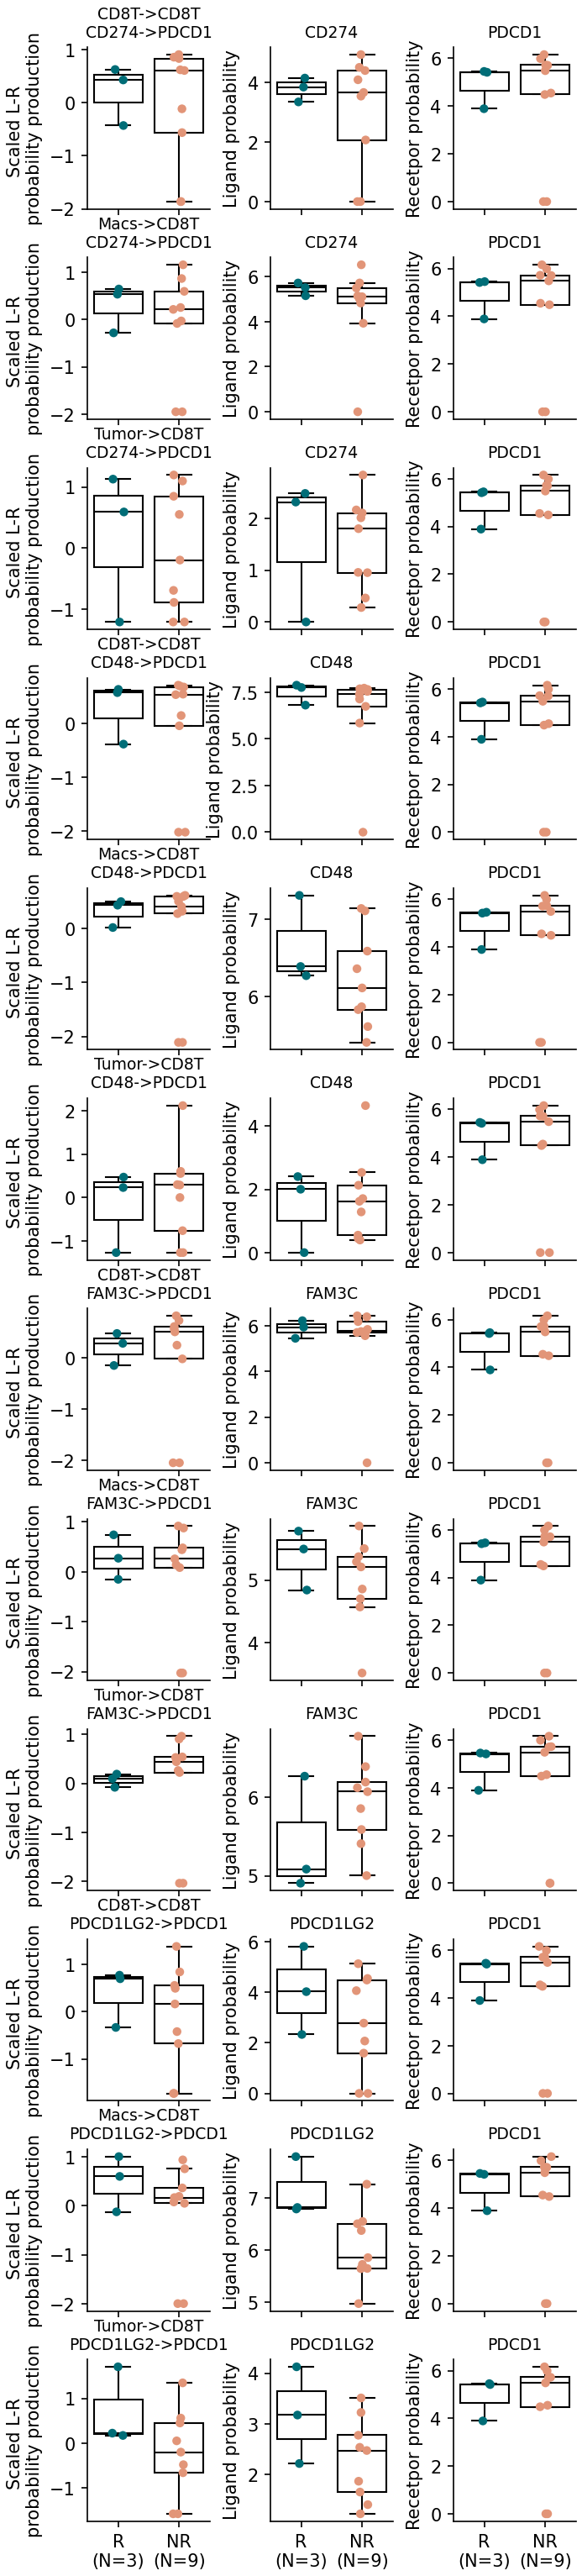

In [5]:
pd1_ids = lr_prob_bl.index[(lr_prob_bl.receptor=='PDCD1')&(lr_prob_bl.receiver=='CD8T')]

pd1_data =lr_prob_bl.loc[pd1_ids,:]
fig,axs = plt.subplots(pd1_data.id.nunique(),3,dpi=150,figsize=(5,pd1_data.id.nunique()*2+2),sharex=False)
order = ['R','NR']
for i,(lr,data) in enumerate(pd1_data.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.3)

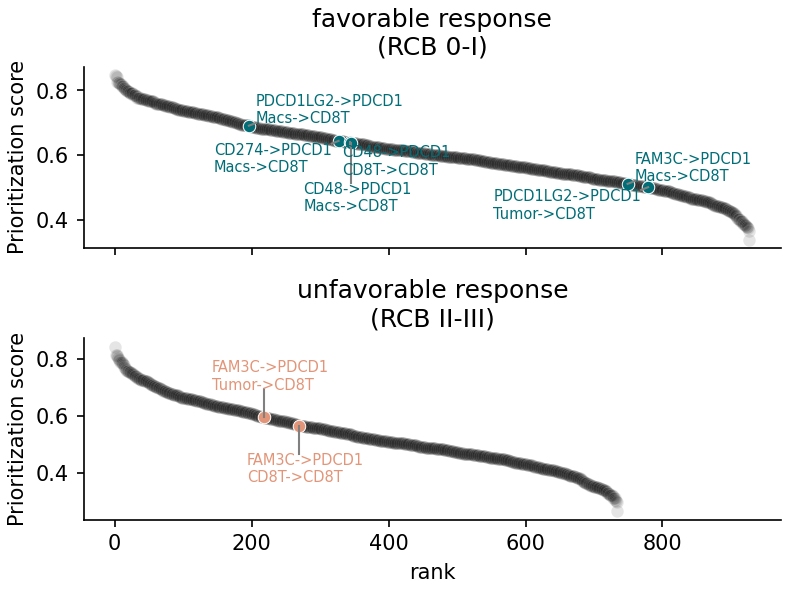

In [6]:
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'

pr_bl_sub = pr_bl.loc[(pr_bl.receiver=='CD8T'),].copy()
ax =axs[0]
group = 'R_Baseline'
data = pr_bl_sub.loc[pr_bl_sub.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.receptor=='PDCD1',:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2]) + '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            min_distance=0.01,
            margin=0.01,
            linecolor='gray')
# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')
ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);
# ax.legend(loc=(0,1),ncols=2)



ax =axs[1]
group = 'NR_Baseline'
data = pr_bl_sub.loc[pr_bl_sub.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.receptor=='PDCD1',:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])


t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2]) + '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            min_distance=0.01,
            margin=0.1,
            linecolor='gray')
ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);
# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left');

plt.subplots_adjust(hspace=.5)

## Tumor-CD8T

In [7]:
theraputic_r=['PDCD1','TIGIT','LAG3','CTLA4','HAVCR2','BTLA']
top_n=50
cd8_tumor_pr_bl = pr_bl.loc[(pr_bl.sender=='Tumor')&
                            (pr_bl.receiver=='CD8T')].copy()

cd8_tumor_pr_bl['rank']= cd8_tumor_pr_bl.groupby(['group'])['prioritization_score'].rank(ascending=False)
lr_ids = (cd8_tumor_pr_bl.
          lr_interaction[(cd8_tumor_pr_bl['rank']<top_n) & (cd8_tumor_pr_bl.receptor.isin(theraputic_r))].
          unique()
         )
lr_ids

array(['NECTIN4_TIGIT', 'NECTIN2_TIGIT', 'WBP1_CTLA4'], dtype=object)

### Immune checkpoints

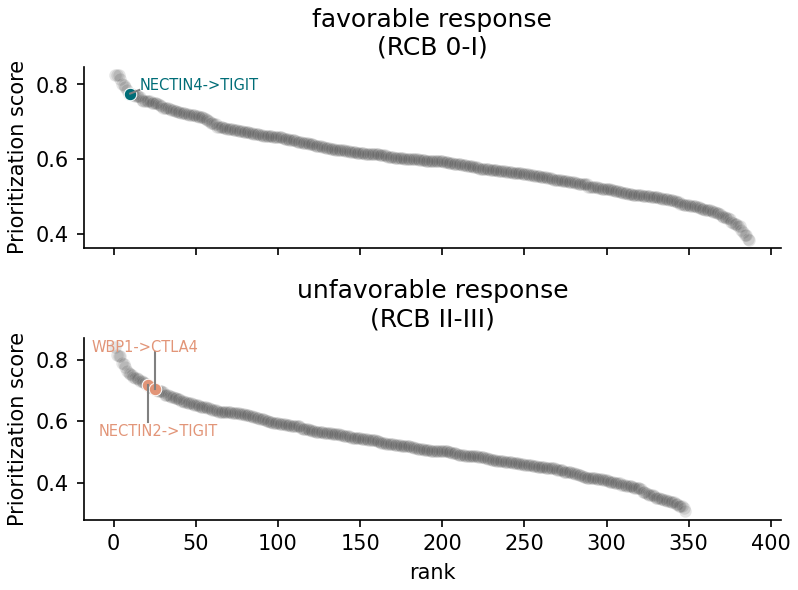

In [8]:
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'


ax =axs[0]
group = 'R_Baseline'
data = cd8_tumor_pr_bl.loc[cd8_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])#,hue='lr_interaction',ax=ax,palette=palette)

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')

t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            linecolor='gray')

ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);
# ax.legend(loc=(0,1),ncols=5)


ax =axs[1]
group = 'NR_Baseline'
data = cd8_tumor_pr_bl.loc[cd8_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')
# ax.legend(loc=(0,-.5),ncols=5)
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            # direction='northeast',
            max_distance=0.29,
            margin=.1,
            linecolor='gray')

ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);


plt.subplots_adjust(hspace=.5)

#### Boxplot view

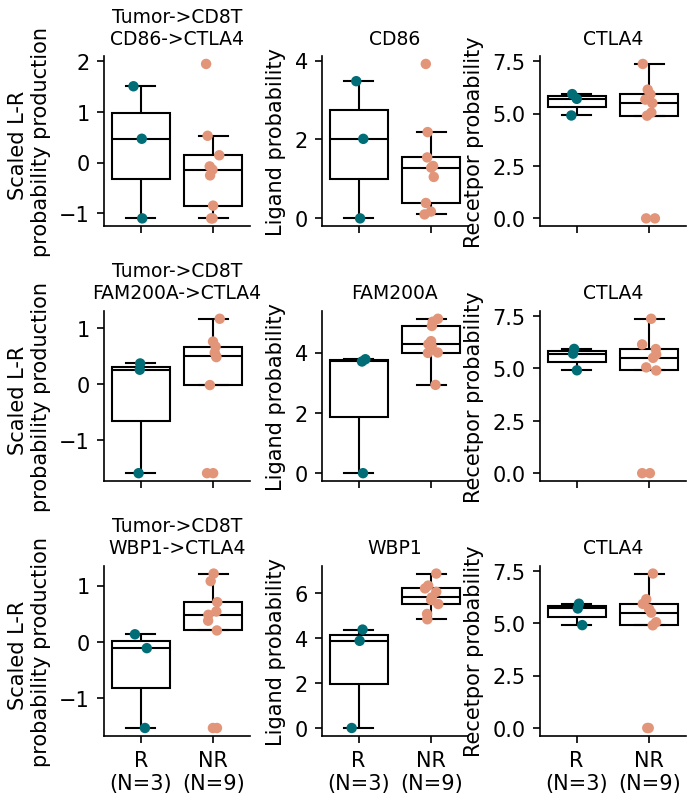

In [9]:
fig,axs = plt.subplots(3,3,dpi=150,figsize=(5,6),sharex=False)
# lr_ids_cell = cd8_tumor_pr_bl.id[cd8_tumor_pr_bl.lr_interaction.isin(['WBP1_CTLA4', 'FAM200A_CTLA4'] )]
lr_ids_cell = cd8_tumor_pr_bl.id[cd8_tumor_pr_bl.receptor=='CTLA4']
dt = lr_prod_bl.loc[lr_prod_bl.id.isin(lr_ids_cell),:]
order = ['R','NR']
for i,(lr,data) in enumerate(dt.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=2:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=2:
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=2:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.5)

## Tumor -Macs 

In [11]:
macs_tumor_pr_bl = pr_bl.loc[(pr_bl.sender.isin(['Tumor']))&
                            (pr_bl.receiver.isin(['Macs']))].copy()
top_n=5

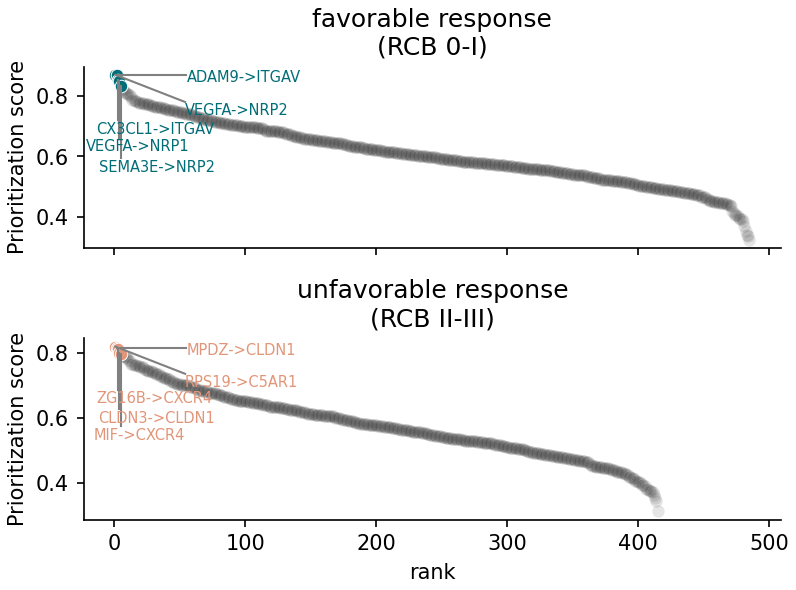

In [11]:
macs_marker_genes = {}
tumor_marker_genes = {}
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'


ax =axs[0]
group = 'R_Baseline'
data = macs_tumor_pr_bl.loc[macs_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.sort_values([y],ascending=False).head(top_n)
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])#,hue='lr_interaction',ax=ax,palette=palette)

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')

t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
macs_marker_genes[group] = sub_data['receptor'].unique().tolist()
tumor_marker_genes[group] = sub_data['ligand'].unique().tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            max_distance=0.29,
            min_distance=.1,
            margin=.001,
            linecolor='gray')

ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);


ax =axs[1]
group = 'NR_Baseline'
data = macs_tumor_pr_bl.loc[macs_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.sort_values([y],ascending=False).head(top_n)
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')
# ax.legend(loc=(0,-.5),ncols=5)
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
macs_marker_genes[group] = sub_data['receptor'].unique().tolist()
tumor_marker_genes[group] = sub_data['ligand'].unique().tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            # direction='northeast',
            max_distance=0.29,
            min_distance=.1,
            margin=.001,
            linecolor='gray')

ax.set(ylabel=y.replace('_',' ').capitalize(),title=group_rename[group]);


plt.subplots_adjust(hspace=.5)

### Boxplot visual

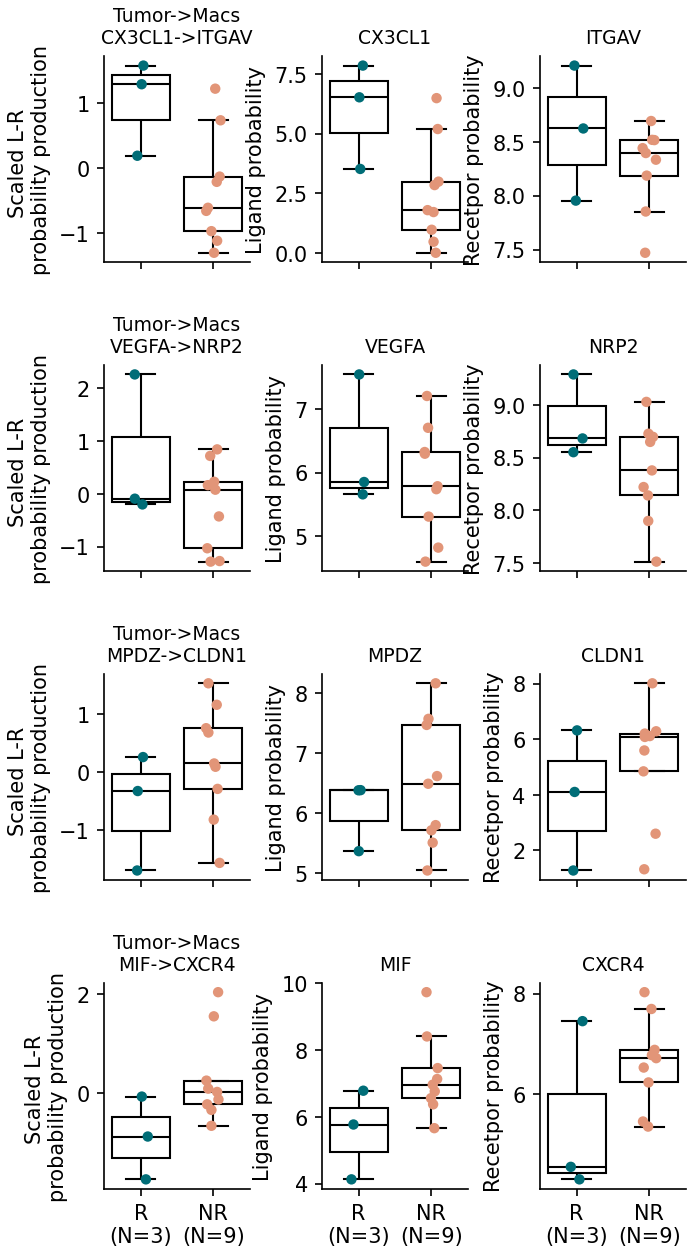

In [12]:
fig,axs = plt.subplots(4,3,dpi=150,figsize=(5,8+2),sharex=False)
macs_tumor_pr_bl['rank'] = macs_tumor_pr_bl.groupby('group')['prioritization_score'].rank(ascending=False)
# lr_ids = macs_tumor_pr_bl.id[ (macs_tumor_pr_bl['rank']<=top_n)]
lr_ids = ['CX3CL1_ITGAV_Tumor_Macs','VEGFA_NRP2_Tumor_Macs','MPDZ_CLDN1_Tumor_Macs','MIF_CXCR4_Tumor_Macs']
dt = lr_prod_bl.loc[lr_prod_bl.id.isin(lr_ids),:].copy()
dt['id'] = pd.Categorical(dt['id'],lr_ids,ordered=True)
order = ['R','NR']
for i,(lr,data) in enumerate(dt.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=3:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=3:
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i != 3:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.5)

# Changes Difference
## Top L-Rs
### Tumor-CD8T

In [18]:
from PyComplexHeatmap import HeatmapAnnotation,anno_simple,ClusterMapPlotter
import matplotlib as mpl
from matplotlib.colors import ListedColormap
colors = ["#5b5095", "#7fa2cd",'#95b8d0', "#fdf0d5","#fec89a","#fc8422","#f4442e"]
my_cmap = ListedColormap(colors, name="my_cmap")

In [19]:
cd8_tumor_pr_delta = pr_delta.loc[(pr_delta.sender.isin(['Tumor','CD8T']))&
                            (pr_delta.receiver.isin(['Tumor','CD8T']))&
                            (pr_delta.sender!=pr_delta.receiver)].copy()
cd8_tumor_pr_delta['rank']= cd8_tumor_pr_delta.groupby(['group'])['prioritization_score'].rank(ascending=False)
top_n = 3
lr_ids =cd8_tumor_pr_delta.id[cd8_tumor_pr_delta['rank']<=top_n]
dt = lr_prod_delta.loc[lr_prod_delta.id.isin(lr_ids),:]
dt['Timepoint'] = dt['group'].map(lambda x:x.split("_")[1])
dt['BCR'] = dt['group'].map(lambda x:x.split("_")[0]).map({
    'R':'favorable response\n(RCB 0-I)',
    'NR':'unfavorable response\n(RCB II-III)'
})
dt['Patient'] = dt['sample'].map(lambda x:x.split('.')[0])
lr_ids

128       ZG16B_CXCR4_Tumor_CD8T
254       CALM1_KCNH1_CD8T_Tumor
536        HLA.B_CD8A_Tumor_CD8T
1598       CD99_PILRB_CD8T_Tumor
1738      SFTPD_LAIR1_Tumor_CD8T
1972    LRRN2_TMEM123_Tumor_CD8T
Name: id, dtype: object

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 78.67083333333333 mm


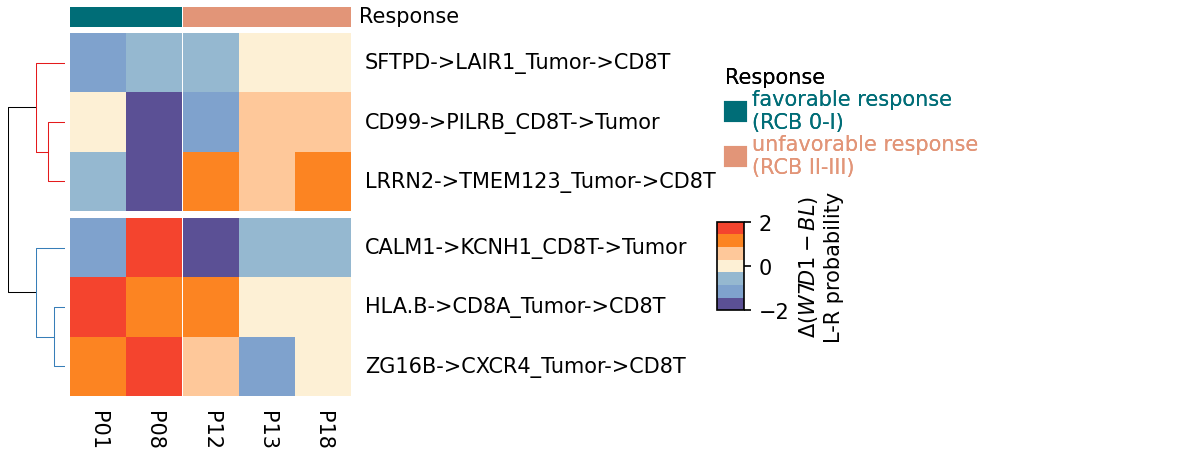

In [20]:
def rename_lrs(name):
    """Reformat the way to name the L-R"""
    l,r,l_c,r_c = name.split('_')
    return f"{l}->{r}_{l_c}->{r_c}"

mtrx = dt.pivot_table(index=['Timepoint','BCR','Patient'],columns=['id'],values='scaled_LR_pb_prod')
delta = (mtrx.loc['W7D1',:] - mtrx.loc['Baseline',:]).reset_index().set_index('Patient')
delta.columns = delta.columns.map(lambda x: x if len(x.split('_')) <4 else rename_lrs(x))
top_anno = delta[['BCR']]
plt.figure(figsize=(3, 3),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.BCR,colors={k:v for k,v in COLOR_PAlETTE['BestResponse'].items() if k !='N/A'},
                                                #{'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                 #                  'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
                                                legend_kws={'frameon':False}),
                           # Patient=anno_simple(top_anno.Patient,
                           #                     colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},
                           #                     legend_kws={'frameon':False})
                          )
cm = ClusterMapPlotter(data=delta.drop(top_anno.columns.tolist(),axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno['BCR'],
                     row_split_gap=1,label=r'$\Delta(W7D1-BL)$'+ '\nL-R probability',row_dendrogram=True,show_rownames=True,show_colnames=True,
                     tree_kws={'row_cmap': 'Set1'},cmap=my_cmap,vmin=-2,vmax=2)
plt.show()

### Tumor-Macrophage

In [21]:
macs_tumor_pr_delta = pr_delta.loc[(pr_delta.sender.isin(['Tumor','Macs']))&
                            (pr_delta.receiver.isin(['Tumor','Macs']))&
                            (pr_delta.sender!=pr_delta.receiver)].copy()

macs_tumor_pr_delta['rank']= macs_tumor_pr_delta.groupby(['group'])['prioritization_score'].rank(ascending=False)

In [22]:
lr_ids = macs_tumor_pr_delta.id[macs_tumor_pr_delta['rank']<=top_n]
dt = lr_prod_delta.loc[lr_prod_delta.id.isin(lr_ids),:]
dt['Timepoint'] = dt['group'].map(lambda x:x.split("_")[1])
dt['BCR'] = dt['group'].map(lambda x:x.split("_")[0]).map({
    'R':'favorable response\n(RCB 0-I)',
    'NR':'unfavorable response\n(RCB II-III)'
})
dt['Patient'] = dt['sample'].map(lambda x:x.split('.')[0])

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 78.67083333333333 mm


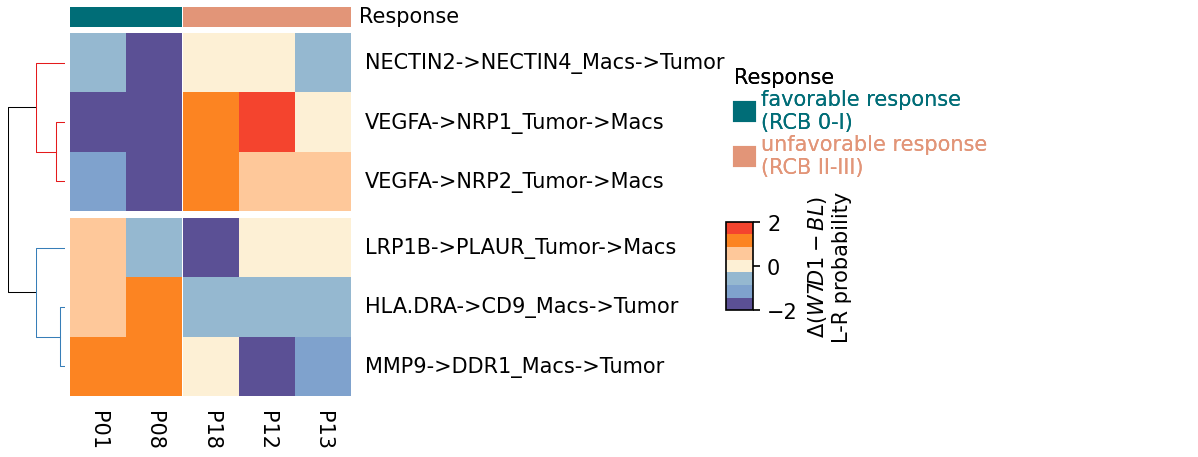

In [23]:
def rename_lrs(name):
    """Reformat the way to name the L-R"""
    l,r,l_c,r_c = name.split('_')
    return f"{l}->{r}_{l_c}->{r_c}"

mtrx = dt.pivot_table(index=['Timepoint','BCR','Patient'],columns=['id'],values='scaled_LR_pb_prod')
delta = (mtrx.loc['W7D1',:] - mtrx.loc['Baseline',:]).reset_index().set_index('Patient')
delta.columns = delta.columns.map(lambda x: x if len(x.split('_')) <4 else rename_lrs(x))
top_anno = delta[['BCR']]
plt.figure(figsize=(3, 3),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.BCR,colors={k:v for k,v in COLOR_PAlETTE['BestResponse'].items() if k !='N/A'},
                                                #{'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                 #                  'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
                                                legend_kws={'frameon':False}),
                           # Patient=anno_simple(top_anno.Patient,
                           #                     colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},
                           #                     legend_kws={'frameon':False})
                          )
cm = ClusterMapPlotter(data=delta.drop(top_anno.columns.tolist(),axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno['BCR'],
                     row_split_gap=1,label=r'$\Delta(W7D1-BL)$'+ '\nL-R probability',row_dendrogram=True,show_rownames=True,show_colnames=True,
                     tree_kws={'row_cmap': 'Set1'},cmap=my_cmap,vmin=-2,vmax=2)
plt.show()

# Cell state changes

In [24]:
from utils.statsTest import lmTest

## CD8 T cells

In [25]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/CD8T/MetaProgram_Annotation.csv',index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(f'{RESULT_TABLE}/MPs/CD8T/signature_scores.csv',index_col=0)
# scores.columns = scores.map(MP_anno_map)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
scores = scores.merge(sample_meta,on='CCG_ID',how='left')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)

In [26]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         2
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W7D1,Naive,0.117923,-0.150865,0.003698579398035714,favorable response\n(RCB 0-I),0.005548
0,Baseline,W7D1,Naive,-0.134514,-0.150865,0.01612511500163772,unfavorable response\n(RCB II-III),0.031215
0,Baseline,W7D1,Exhausted,0.085533,-0.136217,0.022032742221144905,favorable response\n(RCB 0-I),0.022033
0,Baseline,W7D1,Exhausted,0.035863,-0.136217,0.43733663114642196,unfavorable response\n(RCB II-III),0.437337
0,Baseline,W7D1,Naive,0.030148,-0.099349,0.35924173201449805,favorable response\n(RCB 0-I)+unfavorable resp...,0.359242
0,Baseline,W7D1,Exhausted,0.067883,0.099122,0.02114821143810769,favorable response\n(RCB 0-I)+unfavorable resp...,0.031722
0,Baseline,W7D1,Cytotoxic,0.457704,0.386452,1.0465914928399107e-46,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W7D1,Cytotoxic,0.638251,0.395552,6.391613728354662e-58,favorable response\n(RCB 0-I),0.0
0,Baseline,W7D1,Cytotoxic,0.119615,0.395552,0.020810133573886083,unfavorable response\n(RCB II-III),0.031215


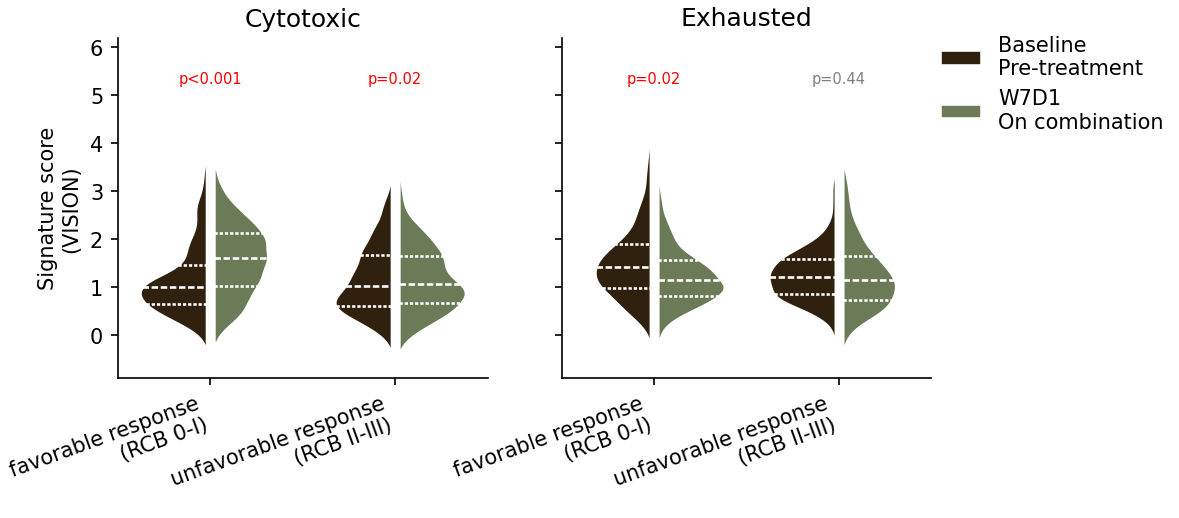

In [27]:
show_mps = ['Cytotoxic','Exhausted']
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,2,dpi=150,sharey=True,figsize=(7,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W7D1':'W7D1\nOn combination'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

In [39]:
cd8 = adata[(adata.obs.Celltype=='CD8T')&(adata.obs.Timepoint.isin(['Baseline','W7D1']))&(adata.obs.Patient.isin(paired_pts)),]
cd8

View of AnnData object with n_obs × n_vars = 4375 × 36601
    obs: 'Sample_Short', 'Sample', 'Compartment', 'Lineage', 'Celltype', 'Cellstate', 'CCG_ID', 'BluePrint', 'AC_Treatment', 'Tech', 'WES_Profile', 'BulkRNA_Profile', 'PAM50', 'BestResponse', 'Timepoint', 'stage', 'Patient', 'Treatment_Arm', 'br_short'
    uns: 'log1p'

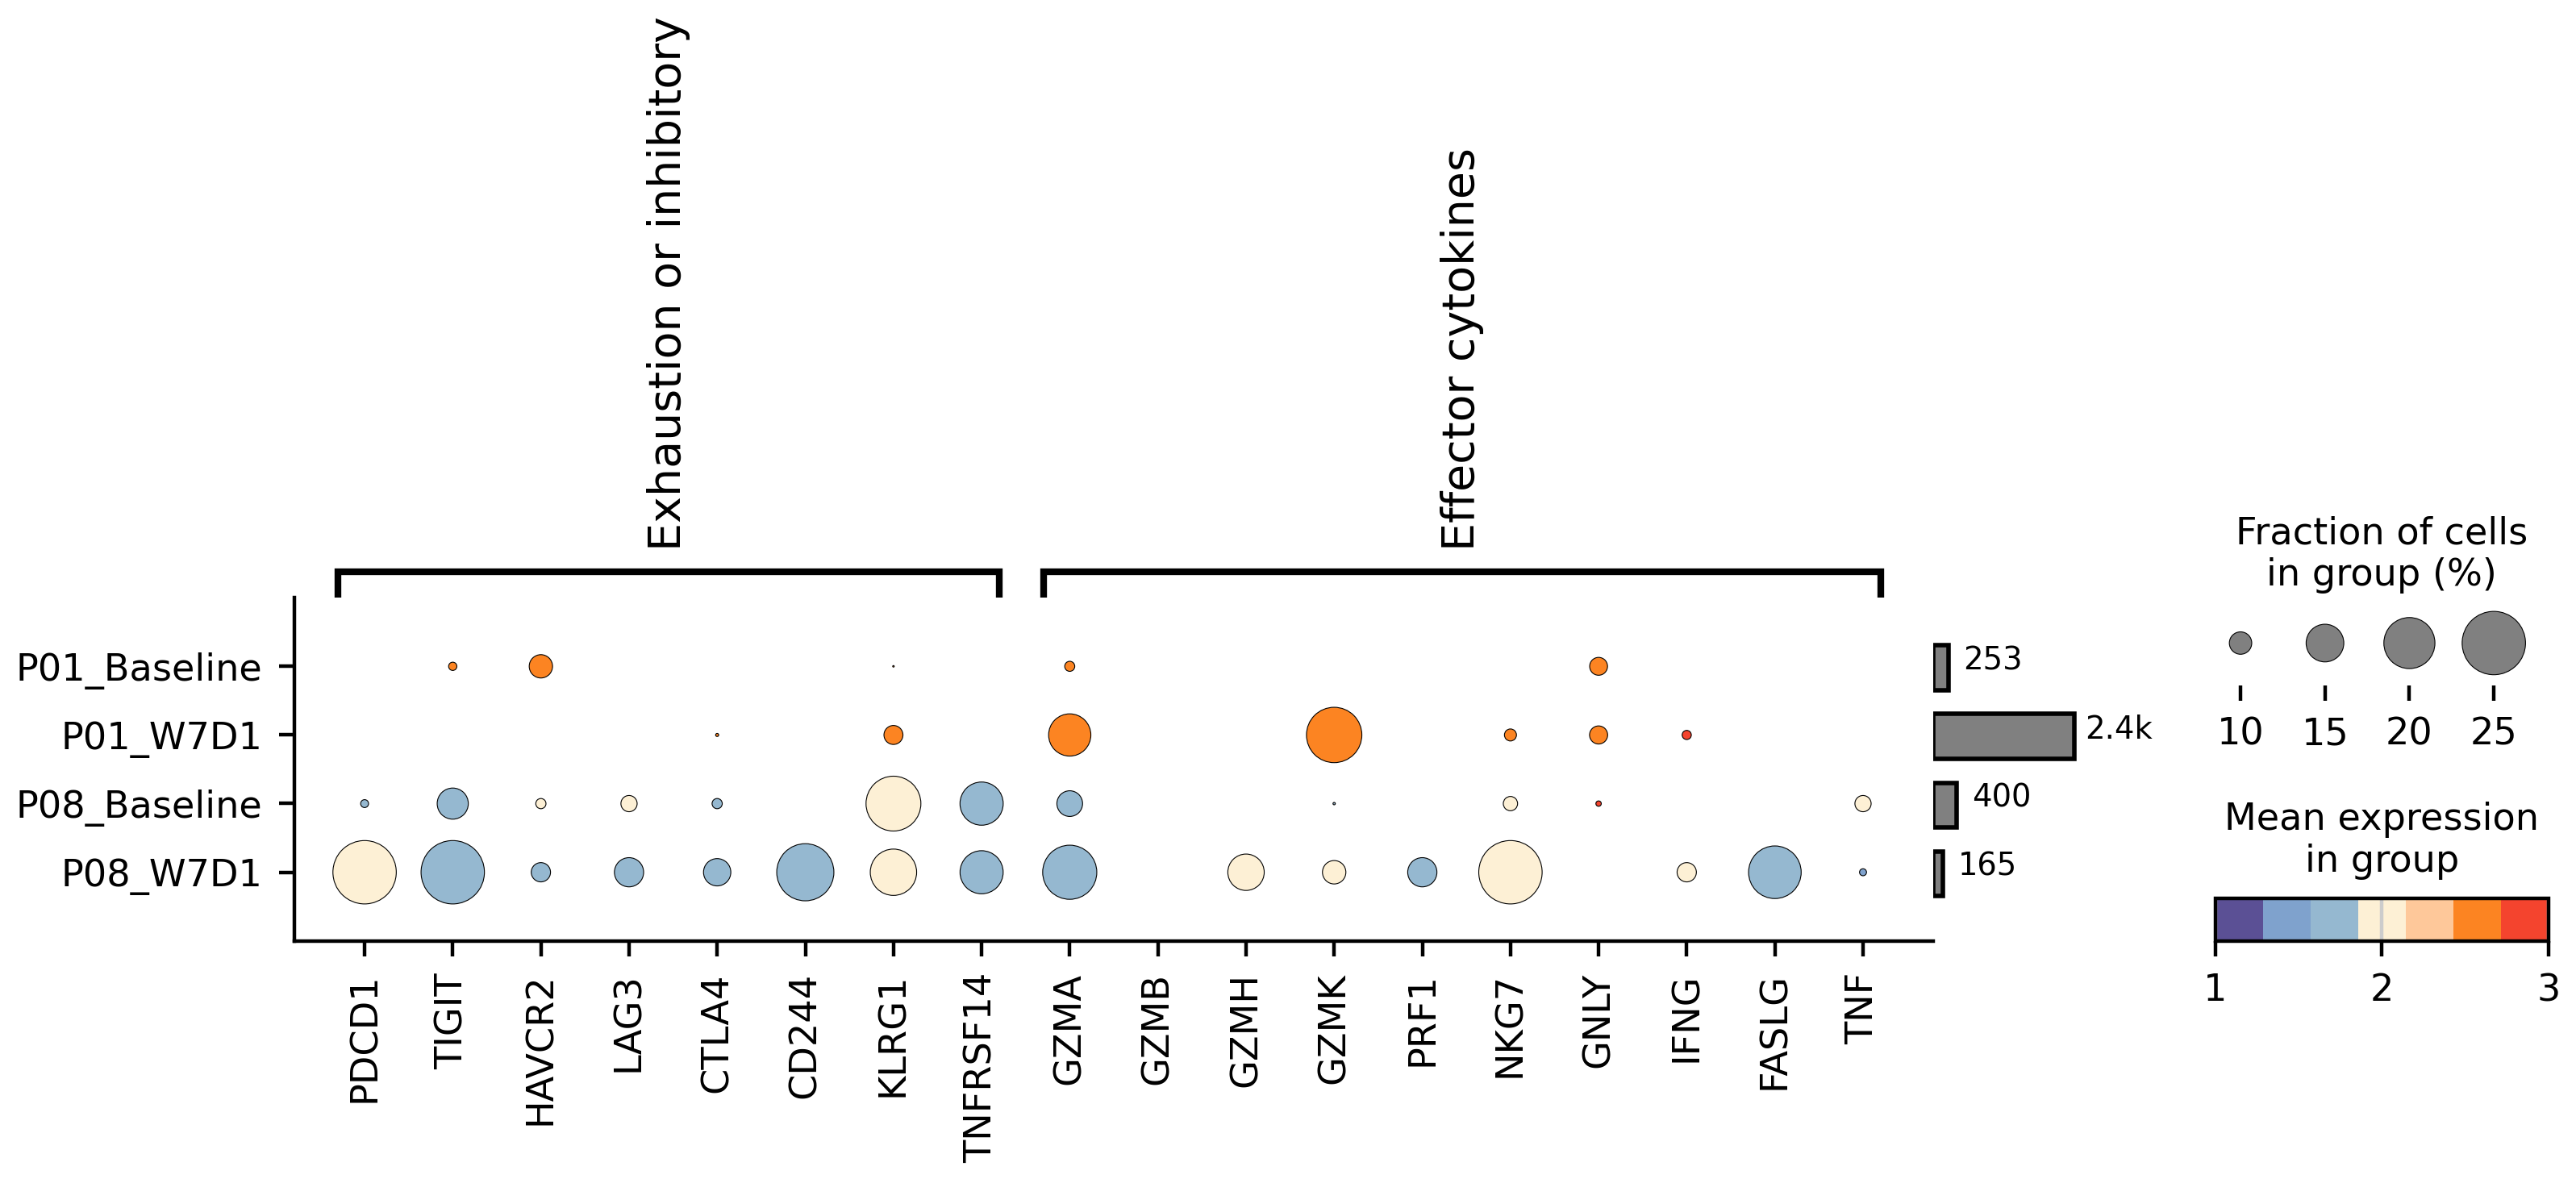

In [85]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
markers = {
     'Exhaustion or inhibitory':['PDCD1','TIGIT','HAVCR2','LAG3','CTLA4','CD244','KLRG1','TNFRSF14'], 
    'Effector cytokines':['GZMA','GZMB','GZMH','GZMK','PRF1','NKG7','GNLY','IFNG','FASLG','TNF'],
}
dp=sc.pl.dotplot(cd8[cd8.obs.BestResponse=='favorable response\n(RCB 0-I)',],
             markers,
             groupby=['Patient','Timepoint'],
             mean_only_expressed=True,
                 vmin=1,vmax=3,
                return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap=my_cmap,dot_max=.25,dot_min=.05)
dp.show()

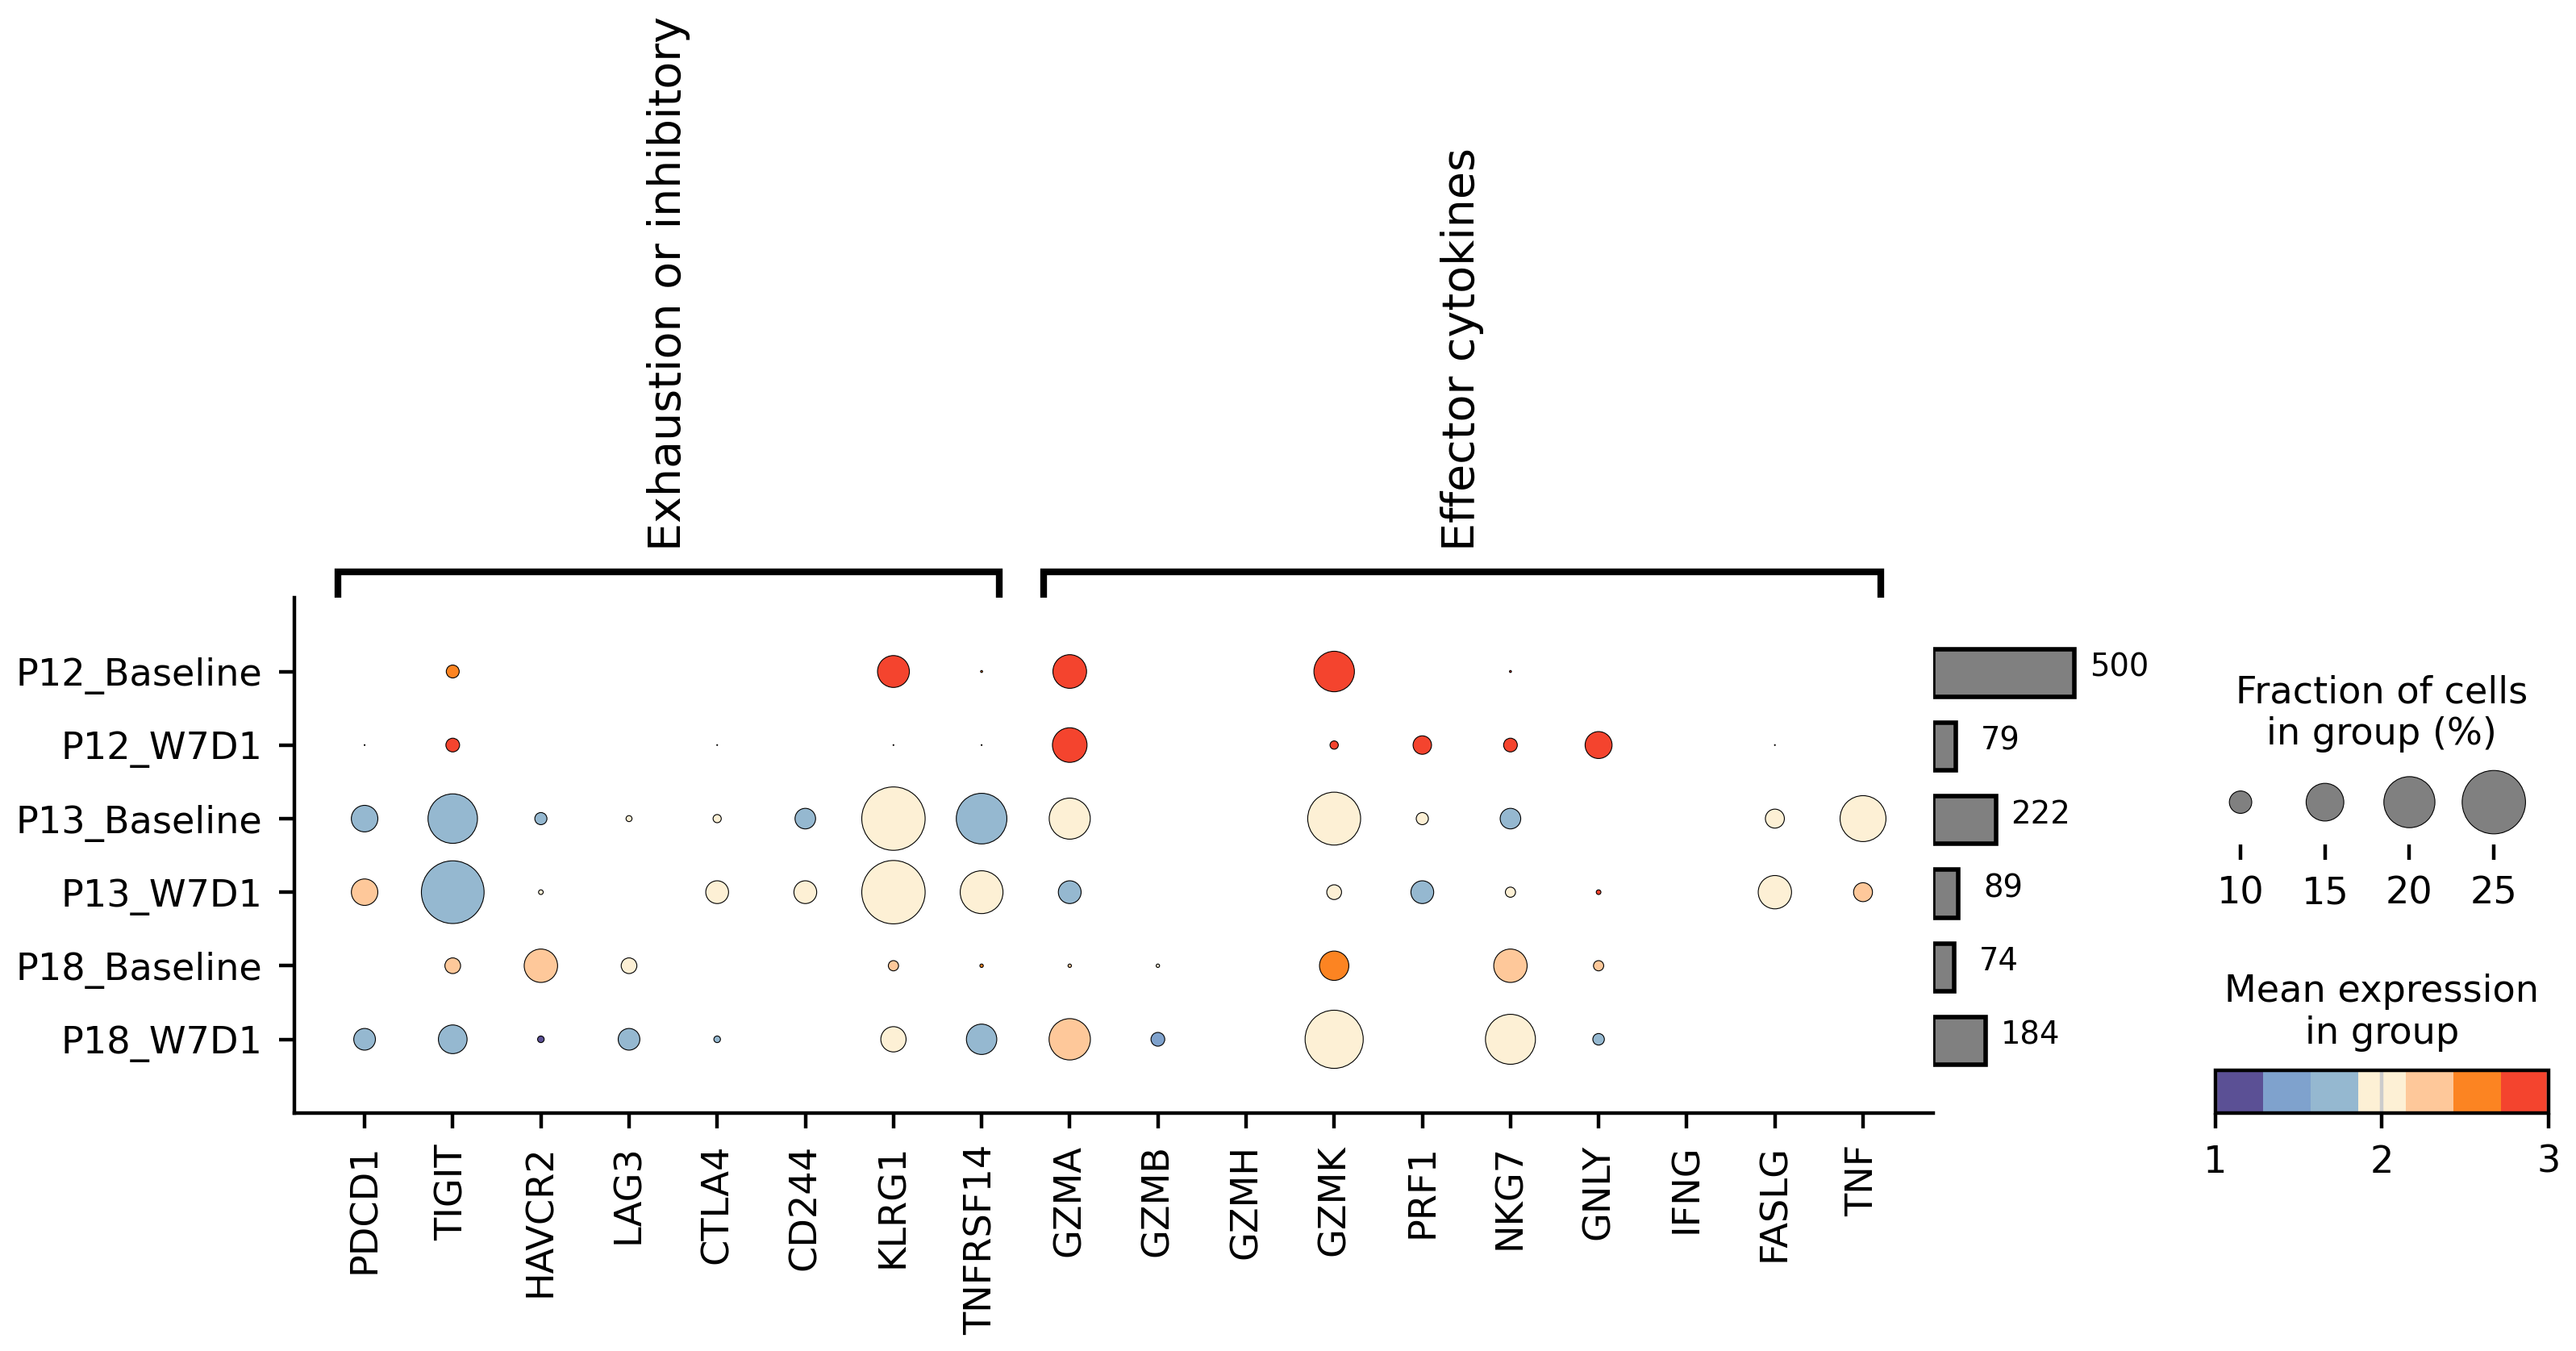

In [86]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp=sc.pl.dotplot(cd8[cd8.obs.BestResponse!='favorable response\n(RCB 0-I)',],
             markers,
             groupby=['Patient','Timepoint'],
             mean_only_expressed=True,
                 vmin=1,vmax=3,
                return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap=my_cmap,dot_max=.25,dot_min=.05)
dp.show()

## Macrophages

### MP signature

In [62]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/MetaProgram_Annotation.csv',index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/signature_scores.csv',index_col=0)
# scores.columns = scores.map(MP_anno_map)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
scores = scores.merge(sample_meta,on='CCG_ID',how='left')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)

In [63]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         2
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W7D1,Adhesion,-0.387582,-0.389403,2.878976322257274e-59,favorable response\n(RCB 0-I),0.0
0,Baseline,W7D1,Adhesion,-0.169781,-0.389403,0.006091739669647671,unfavorable response\n(RCB II-III),0.012183
0,Baseline,W7D1,Secretion,-0.223235,-0.303952,2.7299015779555798e-08,unfavorable response\n(RCB II-III),0.0
0,Baseline,W7D1,Secretion,0.057876,-0.303952,0.008943238906016823,favorable response\n(RCB 0-I),0.008943
0,Baseline,W7D1,Secretion,-0.029954,-0.109521,0.13107224081767246,favorable response\n(RCB 0-I)+unfavorable resp...,0.131072
0,Baseline,W7D1,Adhesion,-0.319914,-0.058677,1.8777539869095703e-36,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W7D1,Endocytosis,0.258785,-0.01171,1.1292572240564862e-20,favorable response\n(RCB 0-I),0.0
0,Baseline,W7D1,Endocytosis,-0.122312,-0.01171,0.0526230169765839,unfavorable response\n(RCB II-III),0.063148
0,Baseline,W7D1,Presentation,0.257542,0.019166,1.6075476102213475e-17,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W7D1,Endocytosis,0.139869,0.041816,3.867579754849602e-07,favorable response\n(RCB 0-I)+unfavorable resp...,0.0


In [95]:
MP_anno_map

{'MP1': 'Endocytosis',
 'MP4': 'Lipid',
 'MP7': 'Interferon',
 'MP6': 'Adhesion',
 'MP5': 'Secretion',
 'MP8': 'Presentation'}

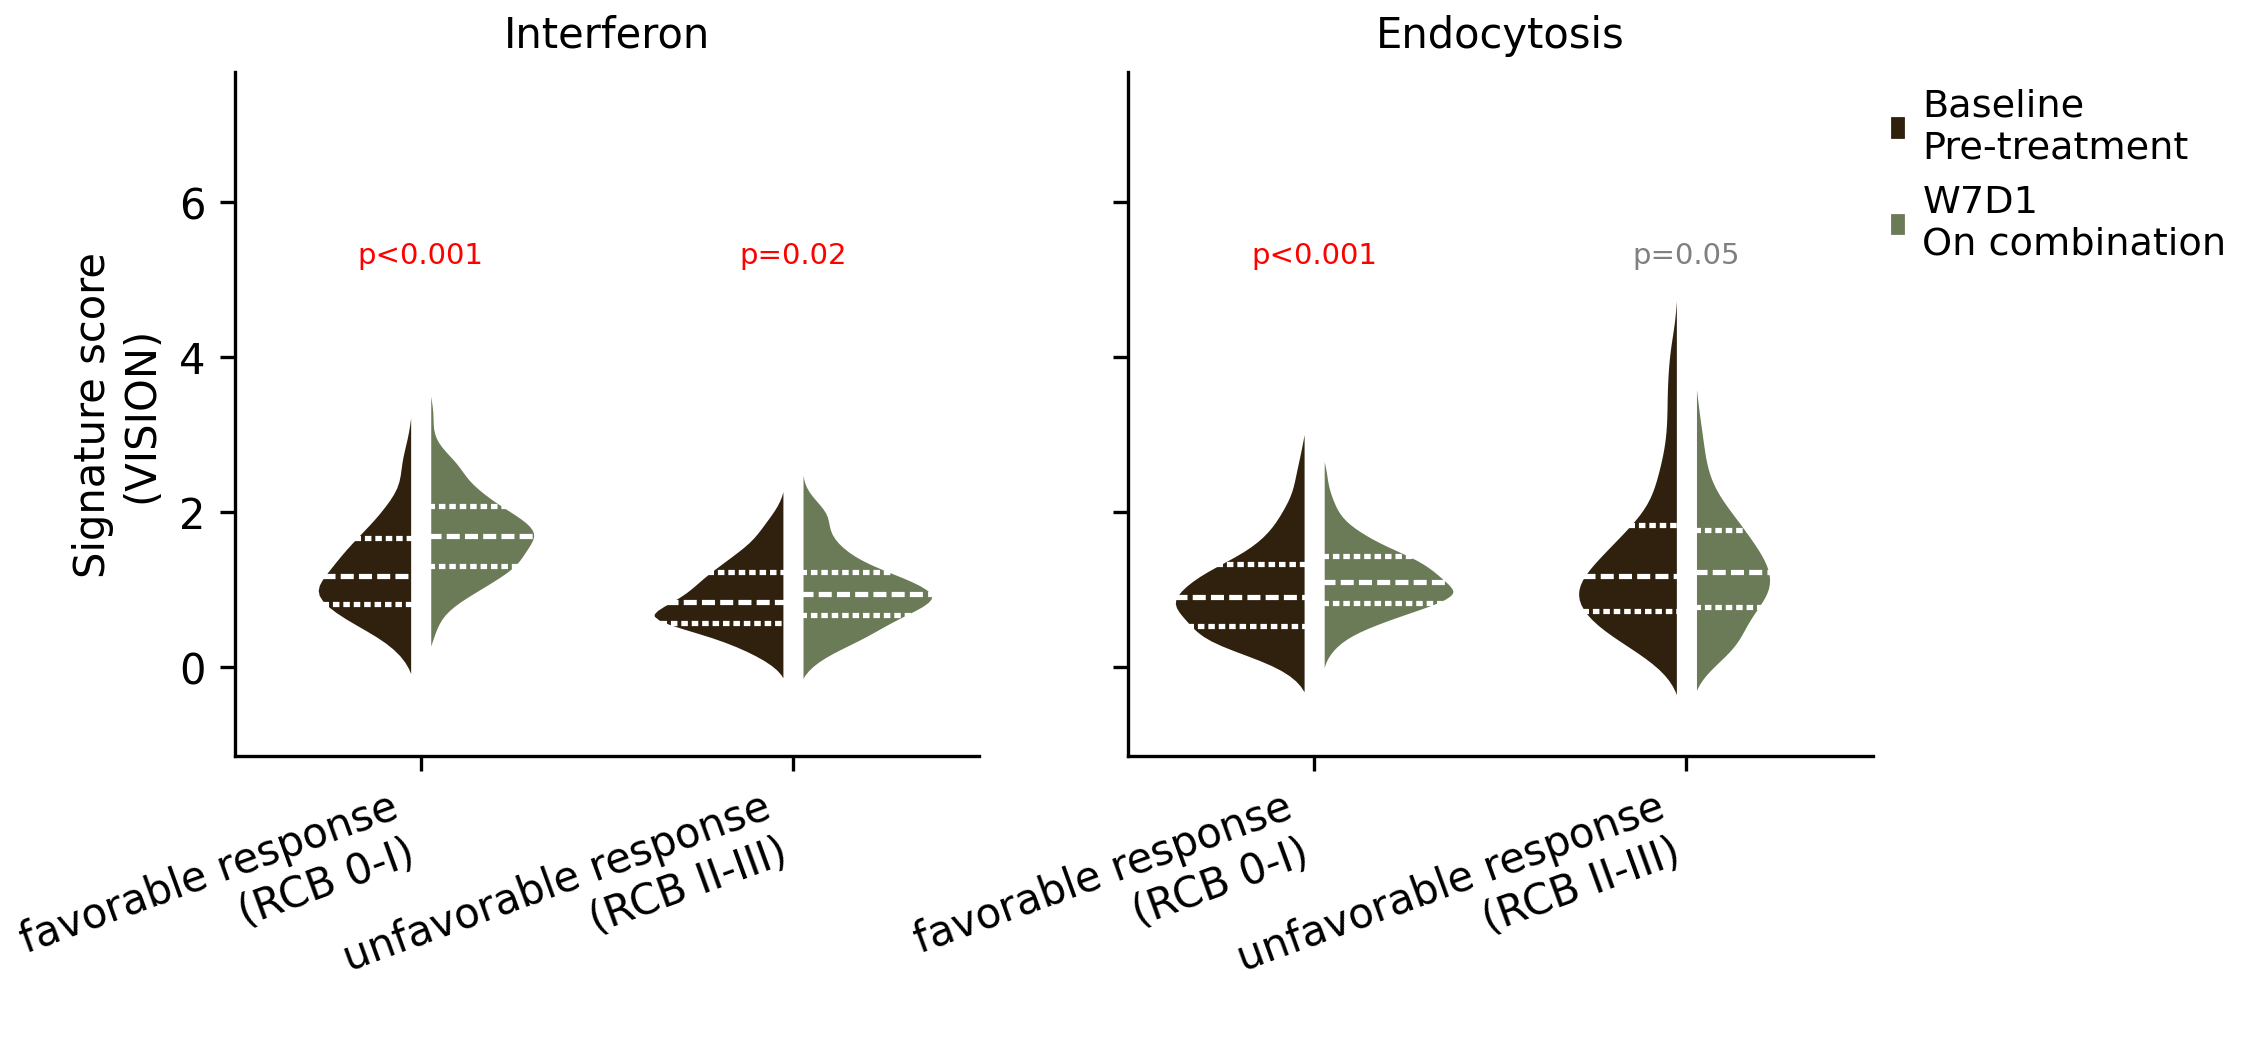

In [94]:
show_mps = ['Interferon','Endocytosis']
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,2,dpi=150,sharey=True,figsize=(7,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] > 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W7D1':'W7D1\nOn combination'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.grid(False)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

In [65]:
macs = adata[(adata.obs.Celltype=='Macs')&(adata.obs.Timepoint.isin(['Baseline','W7D1']))&(adata.obs.Patient.isin(paired_pts)),]
macs

View of AnnData object with n_obs × n_vars = 3410 × 36601
    obs: 'Sample_Short', 'Sample', 'Compartment', 'Lineage', 'Celltype', 'Cellstate', 'CCG_ID', 'BluePrint', 'AC_Treatment', 'Tech', 'WES_Profile', 'BulkRNA_Profile', 'PAM50', 'BestResponse', 'Timepoint', 'stage', 'Patient', 'Treatment_Arm', 'br_short'
    uns: 'log1p'

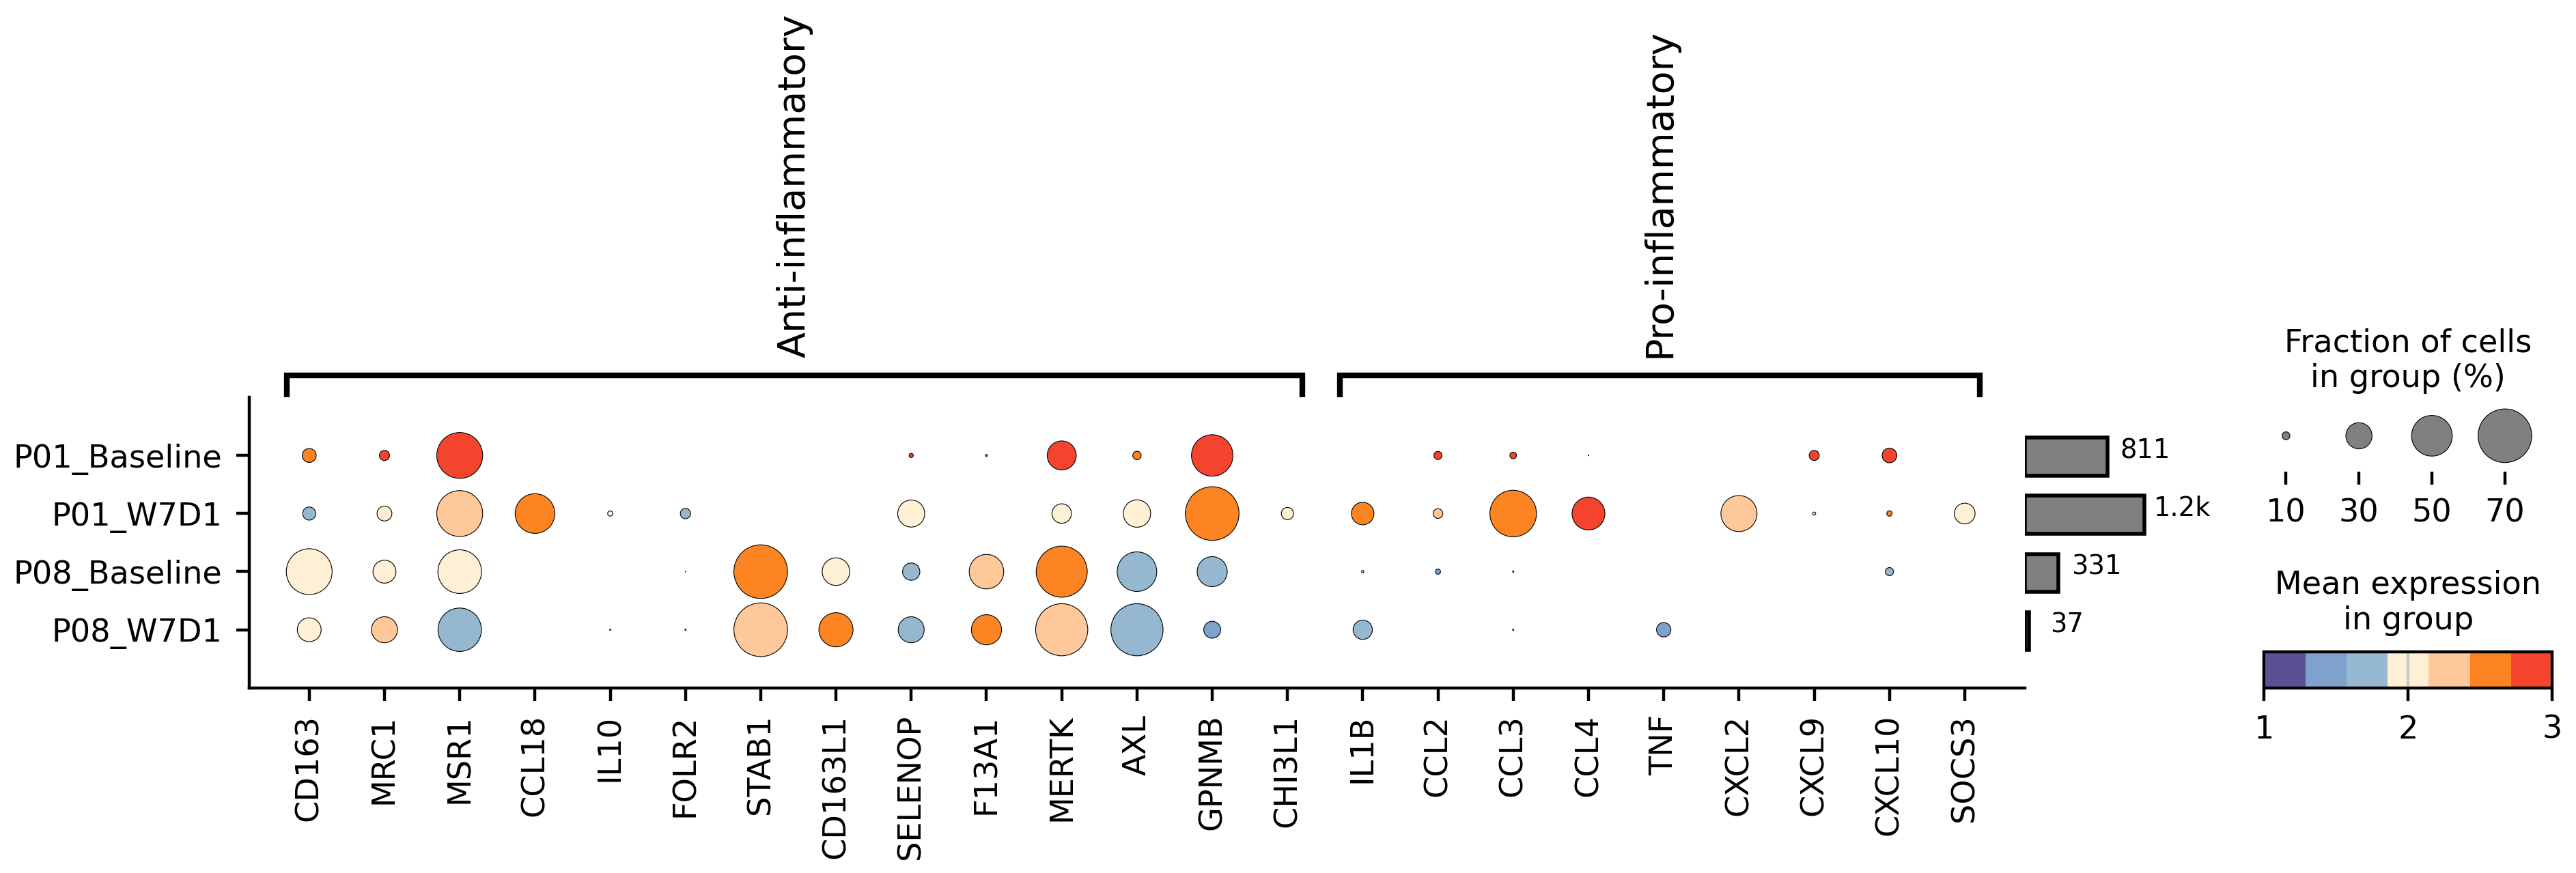

In [91]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
markers = {
    'Anti-inflammatory':['CD163','MRC1','MSR1','CCL18','IL10','FOLR2','STAB1','CD163L1','SELENOP','F13A1','MERTK',
                        'AXL','GPNMB','CHI3L1'],
    'Pro-inflammatory':['IL1B','CCL2','CCL3','CCL4','TNF','CXCL2','CXCL9','CXCL10','SOCS3'],
}
dp=sc.pl.dotplot(macs[macs.obs.BestResponse=='favorable response\n(RCB 0-I)',],
             markers,
             groupby=['Patient','Timepoint'],
             mean_only_expressed=True,
                 vmin=1,vmax=3,
                return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap=my_cmap,dot_max=.7,dot_min=.05)
dp.savefig(f'{FIGURE_FOLDER}/Dotplot_Delta_Macs_M1M2_R.svg',bbox_inches='tight')

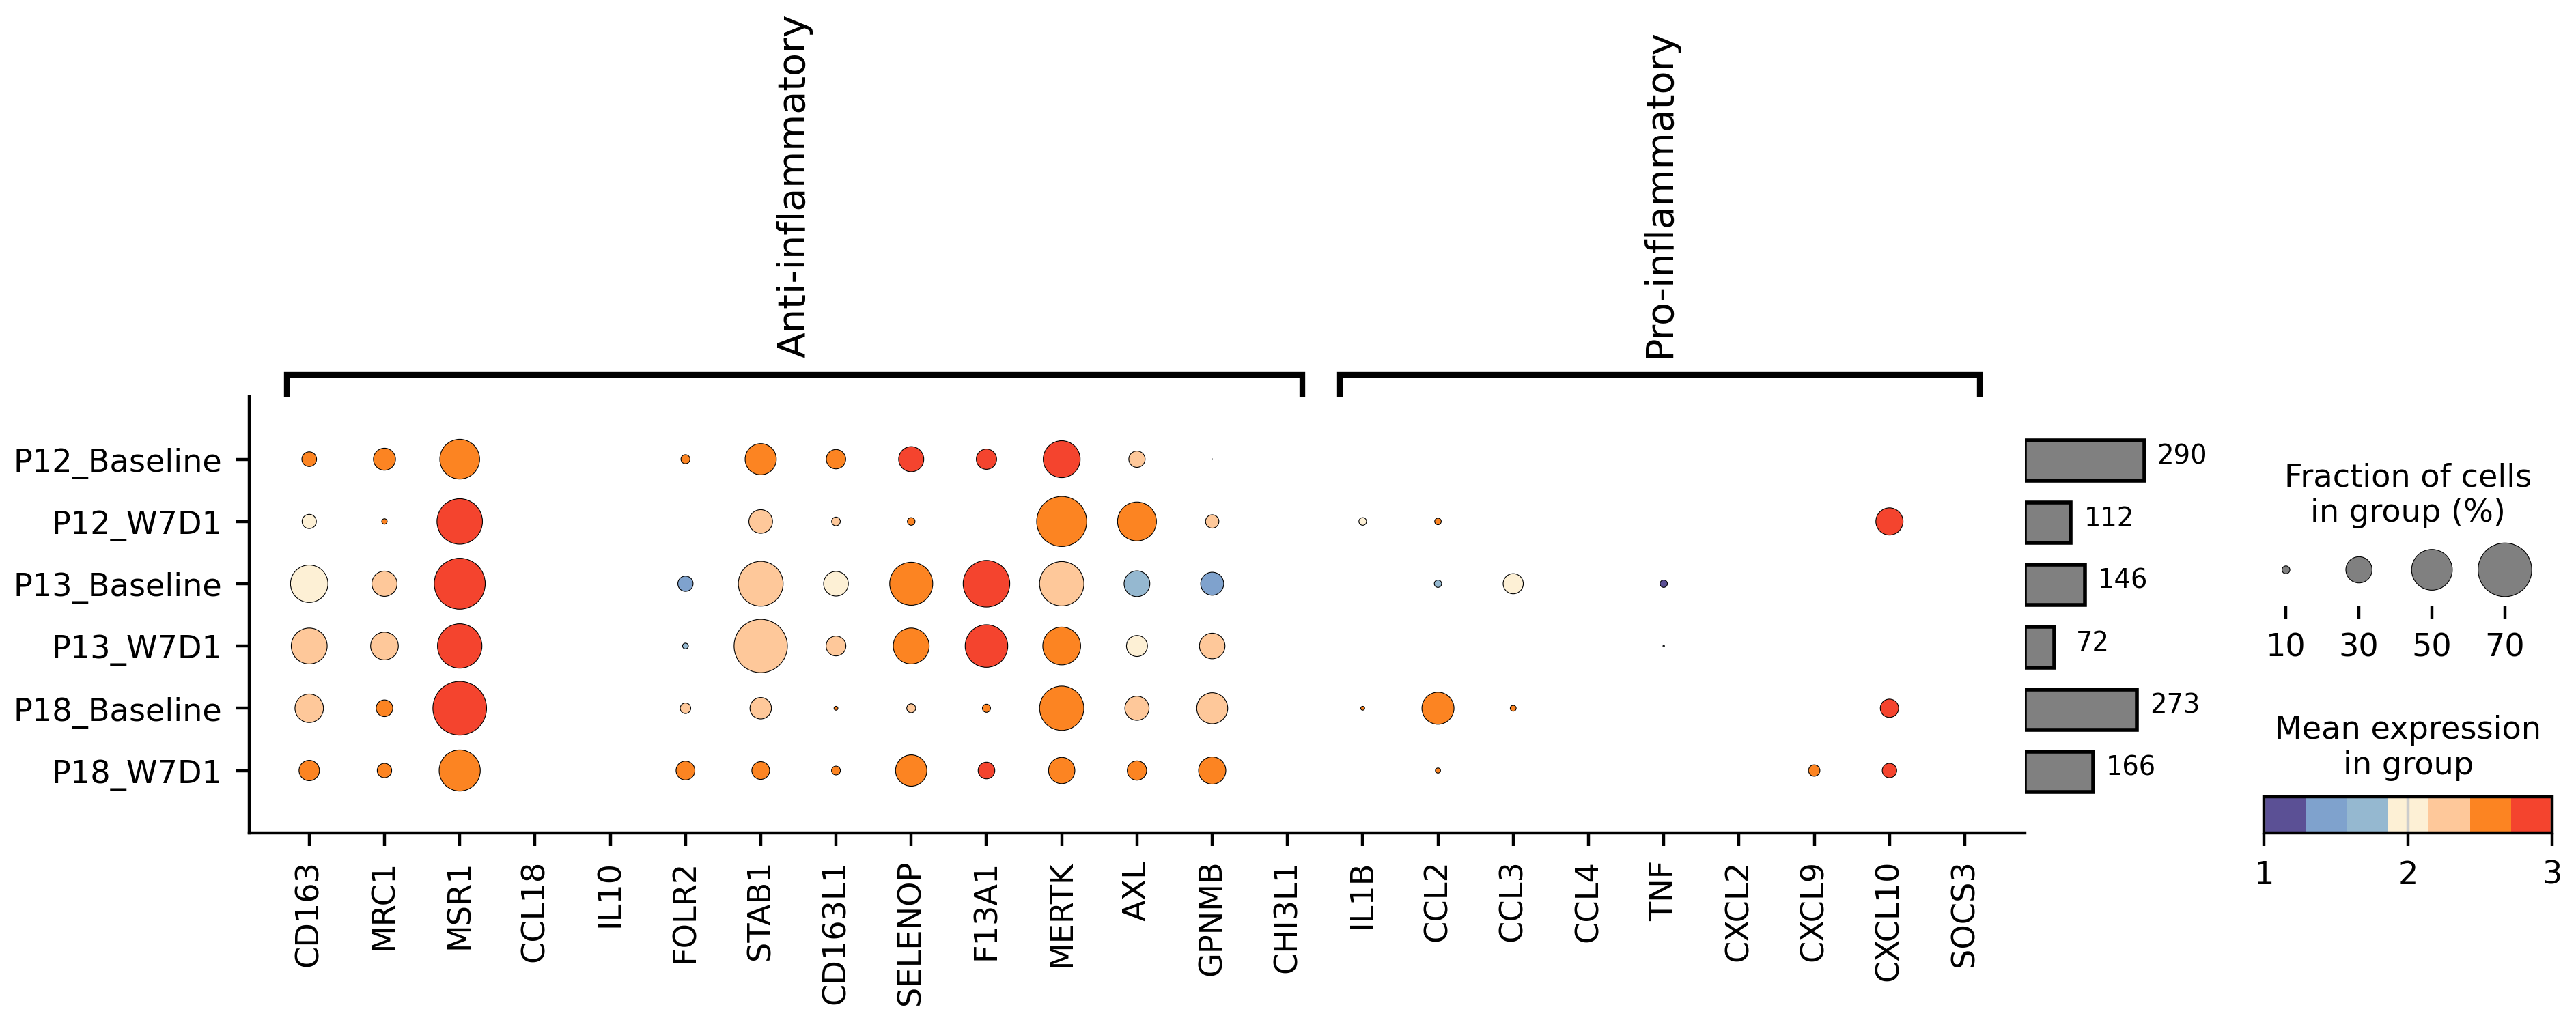

In [90]:
dp=sc.pl.dotplot(macs[macs.obs.BestResponse!='favorable response\n(RCB 0-I)',],
             markers,
             groupby=['Patient','Timepoint'],
             mean_only_expressed=True,
                return_fig=True,
                vmin=1,vmax=3)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap=my_cmap,dot_max=.7,dot_min=.05)
dp.savefig(f'{FIGURE_FOLDER}/Dotplot_Macs_M1M2_NR.svg',bbox_inches='tight')